In [1]:
import os
import json
import math
from datetime import datetime
from pathlib import Path

## Environment
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt


## Core Scientific Stack
import numpy as np

## Machine Learning / Preprocessing (scikit-learn)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Optimization & Persistence
import optuna
import joblib
import contextlib
import sys
import io
import logging
import time

print("All imports loaded successfully")

# Configuration flags
FORCE_RETRAIN = False  # Set to False to load pretrained models when available
# Connect to database and load data
load_dotenv(override=True)

# Setup model directory (handle notebook environment where __file__ is undefined)
try:
    PROJECT_ROOT = Path(__file__).resolve().parent
except NameError:
    # Fallback: assume notebook is inside src; go up one directory if so
    cwd = Path.cwd().resolve()
    if (cwd / 'supervised.ipynb').exists() or (cwd / 'unsupervised.ipynb').exists():
        PROJECT_ROOT = cwd
    else:
        for parent in cwd.parents:
            if (parent / 'requirements.txt').exists() or (parent / 'README.md').exists():
                PROJECT_ROOT = parent / 'src'
                break
        else:
            PROJECT_ROOT = cwd  # final fallback

MODEL_DIR = (PROJECT_ROOT / '..' / 'unsupervised').resolve()
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Models will be saved to: {MODEL_DIR}")

def save_model(model, name: str, extra: dict | None = None):
    """Utility to persist models and optional metadata alongside them.
    Saves model as joblib plus a companion JSON with metadata/hyperparams."""
    timestamp = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    base_name = f"{name}_{timestamp}"
    model_path = MODEL_DIR / f"{base_name}.joblib"
    meta_path = MODEL_DIR / f"{base_name}.json"
    joblib.dump(model, model_path)
    meta = {'model_name': name, 'saved_utc': timestamp}
    if extra:
        meta.update(extra)
    with open(meta_path, 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"Saved model -> {model_path.name}; metadata -> {meta_path.name}")


def load_pretrained_model(name: str):
    """Load a pretrained model if it exists and FORCE_RETRAIN is False.
    
    Returns:
        tuple: (model, metadata_dict) if found, (None, None) if not found or FORCE_RETRAIN=True
    """
    if FORCE_RETRAIN:
        print(f"FORCE_RETRAIN=True, skipping pretrained {name} model loading")
        return None, None
    
    # Find the most recent model file for this name
    model_files = list(MODEL_DIR.glob(f"{name}_*.joblib"))
    if not model_files:
        print(f"No pretrained {name} model found")
        return None, None
    
    # Get the most recent model (by timestamp in filename)
    model_files.sort(key=lambda x: x.stem.split('_')[-1], reverse=True)
    latest_model_path = model_files[0]
    meta_path = latest_model_path.with_suffix('.json')
    
    if not meta_path.exists():
        print(f"Metadata file missing for {name} model, skipping load")
        return None, None
    
    try:
        model = joblib.load(latest_model_path)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        print(f"Loaded pretrained {name} model from {latest_model_path.name}")
        return model, metadata
    except Exception as e:
        print(f"Error loading pretrained {name} model: {e}")
        return None, None


# Initialize model variables (only set to None if not already defined)
if 'pca_optimal' not in globals():
    pca_optimal = None
if 'kmeans_best' not in globals():
    kmeans_best = None
if 'gmm_best' not in globals():
    gmm_best = None

# Model loading patterns
MODEL_GLOB_PATTERNS = {
    'pca_optimal': 'pca_optimal_*.joblib',
    'kmeans_best': 'kmeans_best_*.joblib',
    'gmm_best': 'gmm_best_*.joblib'
}

# Attempt to load pretrained models
loaded_flags = {}
for var, pattern in MODEL_GLOB_PATTERNS.items():
    if globals().get(var) is not None:
        loaded_flags[var] = 'pre-existing'
        continue
    matches = list(MODEL_DIR.glob(pattern))
    if not matches:
        loaded_flags[var] = 'not found'
        continue
    # Sort by modification time to get the truly latest file
    latest = max(matches, key=lambda p: p.stat().st_mtime)
    try:
        globals()[var] = joblib.load(latest)
        meta_file = latest.with_suffix('.json')
        if meta_file.exists():
            with open(meta_file) as f:
                globals()[f"{var}_meta"] = json.load(f)
        # Show the actual file that was loaded
        loaded_flags[var] = f"Loaded: {latest.name}"
        print(f"  {var}: {latest}")
    except Exception as e:
        loaded_flags[var] = f"failed: {e}"
        globals()[var] = None

print("\nAuto-load status:")
for k, v in loaded_flags.items():
    print(f"  {k}: {v}")
print(f"\nFORCE_RETRAIN = {FORCE_RETRAIN}")


# Database connection parameters
db_params = {
    "host": os.getenv("LOCAL_HOST"),
    "user": os.getenv("LOCAL_USER"),
    "password": os.getenv("LOCAL_PW"),
    "port": os.getenv("LOCAL_PORT"),
    "dbname": os.getenv("LOCAL_DB")
}

try:
    conn = psycopg2.connect(**db_params)
    print("Database connection successful")
    sql_query = "SELECT * FROM dev.base_data;"
    df = pd.read_sql_query(sql_query, conn)
    conn.close()
    print("Golden data loaded into DataFrame:")
    print(df.info())
except Exception as e:
    print(f"An error occurred: {e}")

All imports loaded successfully
Models will be saved to: D:\docs\MADS\696-Milestone 2\unsupervised
  pca_optimal: D:\docs\MADS\696-Milestone 2\unsupervised\pca_optimal_20251019T232657Z.joblib
  kmeans_best: D:\docs\MADS\696-Milestone 2\unsupervised\kmeans_best_20251013T011127Z.joblib
  gmm_best: D:\docs\MADS\696-Milestone 2\unsupervised\gmm_best_20251013T011127Z.joblib

Auto-load status:
  pca_optimal: Loaded: pca_optimal_20251019T232657Z.joblib
  kmeans_best: Loaded: kmeans_best_20251013T011127Z.joblib
  gmm_best: Loaded: gmm_best_20251013T011127Z.joblib

FORCE_RETRAIN = False
Database connection successful


C:\Users\Leo\AppData\Local\Temp\ipykernel_11952\3478299325.py:172: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


Golden data loaded into DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23038 entries, 0 to 23037
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school_name             23038 non-null  object 
 1   school_type             23038 non-null  object 
 2   teachers_fte            22550 non-null  float64
 3   enrollment              22863 non-null  float64
 4   grade_eight_enrollment  21613 non-null  float64
 5   math_counts             22507 non-null  float64
 6   math_high_pct           22507 non-null  float64
 7   read_counts             22386 non-null  float64
 8   read_high_pct           22386 non-null  float64
 9   pct_hhi_150k_200k       23038 non-null  float64
 10  pct_hhi_220k_plus       23038 non-null  float64
 11  avg_natwalkind          23038 non-null  float64
 12  total_10_14             23038 non-null  int64  
 13  pct_10_14               23038 non-null  int64  
 14  pct

## 1. Data Overview & Preprocessing



In [2]:
# Basic shape & preview
df_numeric = df.select_dtypes(include=['int64','float64']).copy()
missing_pct = df_numeric.isna().mean().sort_values(ascending=False)
print("Missing value percentage (top 15):")
display(missing_pct.head(15))
imputer = SimpleImputer(strategy='median')
scaled_features = imputer.fit_transform(df_numeric)
scaler = StandardScaler()
X = scaler.fit_transform(scaled_features)
print(f"Feature matrix ready. Shape: {X.shape}")

Missing value percentage (top 15):


grade_eight_enrollment    0.061854
read_counts               0.028301
read_high_pct             0.028301
math_counts               0.023049
math_high_pct             0.023049
teachers_fte              0.021182
enrollment                0.007596
pct_female_10_14          0.004384
pct_hhi_150k_200k         0.000000
pct_hhi_220k_plus         0.000000
avg_natwalkind            0.000000
total_10_14               0.000000
pct_10_14                 0.000000
total_pop                 0.000000
schools_in_zip            0.000000
dtype: float64

Feature matrix ready. Shape: (23038, 16)


## 2. Optimization Helpers

We define metric computation and a utility to optionally apply PCA inside each trial to reduce dimensionality (tuned as a hyperparameter).

In [3]:
X_full = X  

def prepare_features(trial, X_input):
    """Optionally apply PCA controlled by trial hyperparameters."""
    use_pca = trial.suggest_categorical('use_pca', [True, False])
    if use_pca:
        # limit components between 2 and min(50, n_features)
        max_comp = min(50, X_input.shape[1])
        n_components = trial.suggest_int('pca_components', 2, max_comp)
        pca = PCA(n_components=n_components, random_state=42)
        X_red = pca.fit_transform(X_input)
        return X_red, pca
    return X_input, None


def compute_cluster_metrics(X_data, labels):
    # Guard for metrics requiring >1 cluster and fewer than n_samples clusters
    unique_labels = set(labels)
    if len(unique_labels) <= 1 or len(unique_labels) >= len(labels):
        return {
            'silhouette': float('nan'),
            'calinski_harabasz': float('nan'),
            'davies_bouldin': float('nan')
        }
    return {
        'silhouette': silhouette_score(X_data, labels),
        'calinski_harabasz': calinski_harabasz_score(X_data, labels),
        'davies_bouldin': davies_bouldin_score(X_data, labels)
    }


def objective_wrapper(build_model_fn):
    def objective(trial):
        X_trial, pca_obj = prepare_features(trial, X_full)
        model = build_model_fn(trial)
        labels = model.fit_predict(X_trial)
        metrics = compute_cluster_metrics(X_trial, labels)
        # We'll optimize on silhouette (maximize)
        trial.set_user_attr('metrics', metrics)
        if pca_obj is not None:
            trial.set_user_attr('pca_components_actual', getattr(pca_obj, 'n_components_', None))
        return metrics['silhouette']
    return objective

print("Helper functions and metrics ready.")

Helper functions and metrics ready.


## 3. KMeans Optimization
We search hyperparameters: n_clusters, init method, algorithm, optional PCA usage & components.

In [4]:
SUPPRESS_TRIAL_OUTPUT = True 

@contextlib.contextmanager
def silent_stdout(enabled=True):
    if not enabled:
        yield
        return
    new_target = io.StringIO()
    old_stdout = sys.stdout
    try:
        sys.stdout = new_target
        yield
    finally:
        sys.stdout = old_stdout

# Reduce Optuna logging level (shows only WARNING+)
if SUPPRESS_TRIAL_OUTPUT:
    optuna.logging.set_verbosity(optuna.logging.WARNING)
else:
    optuna.logging.set_verbosity(optuna.logging.INFO)

print("Optuna logging suppression active:" , SUPPRESS_TRIAL_OUTPUT)

Optuna logging suppression active: True


In [6]:
#KMeans Hyperparameter Optimization

N_KMEANS_TRIALS = 10  
REUSE_EXISTING_KMEANS_STUDY = True
KMEANS_STUDY_NAME = 'kmeans_clustering'

if REUSE_EXISTING_KMEANS_STUDY and 'study_kmeans' in globals():
    print('[KMeans] Reusing existing Optuna study; skipping optimization.')
else:
    def build_kmeans(trial):
        n_clusters = trial.suggest_int('kmeans_n_clusters', 2, 15)
        init = trial.suggest_categorical('kmeans_init', ['k-means++', 'random'])
        algorithm = trial.suggest_categorical('kmeans_algorithm', ['lloyd', 'elkan'])
        n_init = trial.suggest_categorical('kmeans_n_init', [10, 20, 30, 'auto'])
        return KMeans(
            n_clusters=n_clusters,
            init=init,
            algorithm=algorithm,
            n_init=n_init,
            random_state=42
        )

    print(f"[KMeans] Running optimization (silence trials={SUPPRESS_TRIAL_OUTPUT}) ...")
    with silent_stdout(SUPPRESS_TRIAL_OUTPUT):
        study_kmeans = optuna.create_study(
                                            direction='maximize', 
                                            study_name=KMEANS_STUDY_NAME
                                            )

        def objective_wrapper_with_runtime(build_model_fn):
            base_objective = objective_wrapper(build_model_fn)
            def _inner(trial):
                start = time.time()
                val = base_objective(trial)
                trial.set_user_attr('runtime_sec', time.time() - start)
                return val
            return _inner

        study_kmeans.optimize(
                            objective_wrapper_with_runtime(build_kmeans),
                            n_trials=N_KMEANS_TRIALS,
                            show_progress_bar=not SUPPRESS_TRIAL_OUTPUT
                        )

best_k_params = study_kmeans.best_trial.params
best_k_metrics = study_kmeans.best_trial.user_attrs.get('metrics', {})

print(f"[KMeans] Best Params:\n{best_k_params}\n"
      f"[KMeans] Best Metrics:\n{best_k_metrics}\n"
      f"[KMeans] Best silhouette: {study_kmeans.best_value:.4f}")

# Build results df
kmeans_results = []
for t in study_kmeans.trials:
    row = {**t.params}
    metrics = t.user_attrs.get('metrics', {})
    row.update(metrics)
    row['runtime_sec'] = t.user_attrs.get('runtime_sec')
    # inertia: recompute quickly if silhouette is valid and clusters >1
    try:
        if not np.isnan(metrics.get('silhouette', np.nan)) and 'kmeans_n_clusters' in t.params:
            km_tmp = KMeans(
                n_clusters=t.params['kmeans_n_clusters'],
                init=t.params['kmeans_init'],
                algorithm=t.params['kmeans_algorithm'],
                n_init=t.params.get('kmeans_n_init','auto'),
                random_state=42
            ).fit(X_full)
            row['inertia'] = km_tmp.inertia_
        else:
            row['inertia'] = np.nan
    except Exception:
        row['inertia'] = np.nan
    kmeans_results.append(row)

kmeans_results_df = pd.DataFrame(kmeans_results)
if not kmeans_results_df.empty:
    kmeans_results_df['inertia_rank'] = kmeans_results_df['inertia'].rank(method='min')
    #display(kmeans_results_df.sort_values(['silhouette','inertia'], ascending=[False, True]).head(10))
    print('[KMeans] Summary:')
    print(kmeans_results_df[['silhouette','inertia','runtime_sec']].round(3))
else:
    print('[KMeans] No trials recorded.')

# Save best params and all trial results
print(f"\n[KMeans] Saving best parameters and trial results...")

# Save best parameters to JSON
best_params_data = {
    'study_name': KMEANS_STUDY_NAME,
    'best_trial_number': study_kmeans.best_trial.number,
    'best_value': float(study_kmeans.best_value),
    'best_params': best_k_params,
    'best_metrics': best_k_metrics,
    'n_trials': len(study_kmeans.trials),
    'timestamp': datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
}

best_params_path = MODEL_DIR / 'kmeans_best_params.json'
with open(best_params_path, 'w') as f:
    json.dump(best_params_data, f, indent=2)
print(f"   ✓ Best parameters saved to: {best_params_path}")

trials_csv_path = MODEL_DIR / 'kmeans_all_trials.csv'
kmeans_results_df.to_csv(trials_csv_path, index=False)
print(f"   ✓ All trial results saved to: {trials_csv_path}")

print(f"\n{'='*80}")
print(f"SUMMARY: KMeans Optuna Optimization Complete")
print(f"{'='*80}")
print(f"Best Trial: #{best_params_data['best_trial_number']}")
print(f"Best Silhouette Score: {best_params_data['best_value']:.4f}")
print(f"Total Trials: {best_params_data['n_trials']}")
print(f"Results saved to: {MODEL_DIR}")
print(f"{'='*80}")

[KMeans] Reusing existing Optuna study; skipping optimization.
[KMeans] Best Params:
{'use_pca': True, 'pca_components': 4, 'kmeans_n_clusters': 10, 'kmeans_init': 'k-means++', 'kmeans_algorithm': 'lloyd', 'kmeans_n_init': 30}
[KMeans] Best Metrics:
{'silhouette': 0.2661585951456155, 'calinski_harabasz': 5933.4381040854005, 'davies_bouldin': 1.1893886532936617}
[KMeans] Best silhouette: 0.2662
[KMeans] Summary:
   silhouette     inertia  runtime_sec
0       0.266  142554.640        8.644
1       0.185  149836.830        6.321
2       0.192  128431.835        7.290
3       0.191  123599.571        8.195
4       0.234  157192.808        6.976
5       0.202  132188.866        6.950
6         NaN         NaN          NaN

[KMeans] Saving best parameters and trial results...
   ✓ Best parameters saved to: D:\docs\MADS\696-Milestone 2\unsupervised\kmeans_best_params.json
   ✓ All trial results saved to: D:\docs\MADS\696-Milestone 2\unsupervised\kmeans_all_trials.csv

SUMMARY: KMeans Optuna O

## PCA - Dimensionality Reduction Model

**Evaluation Metrics (per framework):**
- **Reconstruction error** (MSE between original and reconstructed data)
- **Variance retained** (cumulative explained variance ratio)
- **Visualization quality** (2D/3D projections interpretability)
- **Downstream performance** (clustering quality on reduced features)

In [ ]:
# --- PCA Dimensionality Reduction: Analysis ---
from sklearn.metrics import mean_squared_error

print("="*80)
print(" " * 20 + "PCA DIMENSIONALITY REDUCTION ANALYSIS")
print("="*80)

# 1. Fit PCA with all components to analyze variance distribution
print("\n[PCA] Step 1: Analyzing variance across all components...")
pca_full = PCA(random_state=42)
pca_full.fit(X_full)

cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Key thresholds
n_80 = np.argmax(cumsum_variance >= 0.80) + 1
n_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"\nComponents needed for variance thresholds:\n"
      f"   80% variance: {n_80} components\n"
      f"   90% variance: {n_90} components\n"
      f"   95% variance: {n_95} components\n"
      f"   99% variance: {n_99} components\n"
      f"   Total available: {X_full.shape[1]} features")

# 2. Elbow method - evaluate reconstruction error vs n_components
print("\n[PCA] Step 2: Computing reconstruction errors for elbow analysis...")
n_components_range = list(range(2, min(51, X_full.shape[1]), 2))
reconstruction_errors = []
variance_retained_list = []

for n in n_components_range:
    pca_temp = PCA(n_components=n, random_state=42)
    X_transformed = pca_temp.fit_transform(X_full)
    X_reconstructed = pca_temp.inverse_transform(X_transformed)
    mse = mean_squared_error(X_full, X_reconstructed)
    reconstruction_errors.append(mse)
    variance_retained_list.append(pca_temp.explained_variance_ratio_.sum())
    
    if n % 10 == 0:
        print(f"   Evaluated {n} components: MSE={mse:.6f}, Variance={pca_temp.explained_variance_ratio_.sum():.4f}")

# Find elbow using second derivative
reconstruction_errors_arr = np.array(reconstruction_errors)
if len(reconstruction_errors_arr) > 2:
    second_derivative = np.diff(reconstruction_errors_arr, n=2)
    elbow_idx = np.argmax(second_derivative > 0) + 2
    elbow_n = n_components_range[min(elbow_idx, len(n_components_range)-1)]
else:
    elbow_n = n_95

print(f"\n[PCA] Elbow method suggests: {elbow_n} components\n"
      f"[PCA] 95% variance threshold: {n_95} components")

# Choose final n_components (balance between compression and information retention)
final_n_components = n_95
print(f"\n[PCA] Selected: {final_n_components} components (95% variance threshold)")

# 3. Fit optimal PCA model
print(f"\n[PCA] Step 3: Fitting final PCA model with {final_n_components} components...")
pca_optimal = PCA(n_components=final_n_components, random_state=42)
X_reduced = pca_optimal.fit_transform(X_full)
X_reconstructed_final = pca_optimal.inverse_transform(X_reduced)

# 4. Calculate comprehensive metrics
print("\n[PCA] Step 4: Computing performance metrics...")

# Reconstruction error
final_reconstruction_error = mean_squared_error(X_full, X_reconstructed_final)
final_rmse = np.sqrt(final_reconstruction_error)

# Variance metrics
final_variance_retained = pca_optimal.explained_variance_ratio_.sum()
final_variance_lost = 1 - final_variance_retained

# Dimensionality metrics
dimensionality_reduction_pct = (1 - final_n_components / X_full.shape[1]) * 100
compression_ratio = X_full.shape[1] / final_n_components

# Per-feature reconstruction error
feature_reconstruction_errors = np.mean((X_full - X_reconstructed_final) ** 2, axis=0)

pca_metrics = {
    'n_components': int(final_n_components),
    'original_dimensions': int(X_full.shape[1]),
    'reduced_dimensions': int(final_n_components),
    'dimensionality_reduction_pct': float(dimensionality_reduction_pct),
    'reconstruction_error_mse': float(final_reconstruction_error),
    'reconstruction_error_rmse': float(final_rmse),
    'variance_retained': float(final_variance_retained),
    'variance_lost': float(final_variance_lost),
    'compression_ratio': float(compression_ratio),
    'explained_variance_per_component': pca_optimal.explained_variance_ratio_.tolist(),
    'cumulative_variance': np.cumsum(pca_optimal.explained_variance_ratio_).tolist(),
    'singular_values': pca_optimal.singular_values_.tolist(),
    'mean_feature_reconstruction_error': float(np.mean(feature_reconstruction_errors)),
    'max_feature_reconstruction_error': float(np.max(feature_reconstruction_errors))
}

# Display metrics
print(f"\n{'='*80}\n"
      f"{' ' * 25}PCA PERFORMANCE METRICS\n"
      f"{'='*80}")

print(f"\nDIMENSIONALITY REDUCTION:\n"
      f"   Original dimensions:     {pca_metrics['original_dimensions']}\n"
      f"   Reduced dimensions:      {pca_metrics['reduced_dimensions']}\n"
      f"   Reduction percentage:    {pca_metrics['dimensionality_reduction_pct']:.1f}%\n"
      f"   Compression ratio:       {pca_metrics['compression_ratio']:.2f}x")

print(f"\nRECONSTRUCTION QUALITY:\n"
      f"   Mean Squared Error:      {pca_metrics['reconstruction_error_mse']:.6f}\n"
      f"   Root Mean Squared Error: {pca_metrics['reconstruction_error_rmse']:.6f}\n"
      f"   Mean per-feature error:  {pca_metrics['mean_feature_reconstruction_error']:.6f}\n"
      f"   Max per-feature error:   {pca_metrics['max_feature_reconstruction_error']:.6f}")

print(f"\nVARIANCE RETENTION:\n"
      f"   Variance retained:       {pca_metrics['variance_retained']:.4f} ({pca_metrics['variance_retained']*100:.2f}%)\n"
      f"   Variance lost:           {pca_metrics['variance_lost']:.4f} ({pca_metrics['variance_lost']*100:.2f}%)")

print(f"\nTOP 10 PRINCIPAL COMPONENTS (Individual Variance):")
for i in range(min(10, final_n_components)):
    var = pca_optimal.explained_variance_ratio_[i]
    cumvar = np.sum(pca_optimal.explained_variance_ratio_[:i+1])
    print(f"   PC{i+1:2d}: {var:.4f} ({var*100:5.2f}%) | Cumulative: {cumvar:.4f} ({cumvar*100:5.2f}%)")

# 5. Component analysis - feature loadings
print(f"\n[PCA] Step 5: Analyzing feature contributions to principal components...")

feature_names = df_numeric.columns.tolist()
loadings = pca_optimal.components_  # Shape: (n_components, n_features)

# Create component importance DataFrame
component_importance = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(final_n_components)],
    'Variance_Explained': pca_optimal.explained_variance_ratio_,
    'Cumulative_Variance': np.cumsum(pca_optimal.explained_variance_ratio_),
    'Singular_Value': pca_optimal.singular_values_
})

print(f"\nComponent Summary Table:")
display(component_importance.head(20))

# Top features per PC
print(f"\nTOP 5 CONTRIBUTING FEATURES PER PRINCIPAL COMPONENT:")
for pc_idx in range(min(5, final_n_components)):
    pc_name = f'PC{pc_idx+1}'
    abs_loadings = np.abs(loadings[pc_idx])
    top_indices = np.argsort(abs_loadings)[-5:][::-1]
    var_explained = pca_optimal.explained_variance_ratio_[pc_idx]
    
    print(f"\n   {pc_name} (Variance: {var_explained:.4f} = {var_explained*100:.2f}%):")
    for rank, idx in enumerate(top_indices, 1):
        loading = loadings[pc_idx][idx]
        print(f"      {rank}. {feature_names[idx]:<40s}: {loading:+.4f}")

# Find features with highest overall contribution (sum of absolute loadings)
feature_importance_pca = pd.DataFrame({
    'Feature': feature_names,
    'Total_Abs_Loading': np.sum(np.abs(loadings), axis=0),
    'Max_Abs_Loading': np.max(np.abs(loadings), axis=0),
    'Reconstruction_Error': feature_reconstruction_errors
})
feature_importance_pca = feature_importance_pca.sort_values('Total_Abs_Loading', ascending=False)

print(f"\nTOP 10 MOST IMPORTANT FEATURES (Overall Contribution):")
display(feature_importance_pca.head(10))

In [ ]:
# --- PCA Visualizations ---

print(f"\n[PCA] Step 6: Generating visualizations...")

fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, hspace=0.35, wspace=0.55)


ax2 = fig.add_subplot(gs[0, 0])
n_bars = min(20, final_n_components)
bars = ax2.bar(range(1, n_bars+1), pca_optimal.explained_variance_ratio_[:n_bars], 
        color='steelblue', alpha=0.7, edgecolor='black', label='Individual Variance')
ax2.set_xlabel('Principal Component', fontsize=11)
ax2.set_ylabel('Individual Variance Explained', fontsize=11)
ax2.set_title(f'Chart 7. PCA - Variance Explained Top {n_bars} Components', fontsize=13, fontweight='bold', loc='center')
ax2.grid(axis='y', alpha=0.5)

# Secondary axis for cumulative variance
ax2_twin = ax2.twinx()
cum_var_top = np.cumsum(pca_optimal.explained_variance_ratio_[:n_bars])
line, = ax2_twin.plot(range(1, n_bars+1), cum_var_top, 'ro-', linewidth=2, markersize=4, label='Cumulative Variance')
ax2_twin.set_ylabel('Cumulative Variance Explained', fontsize=11, color='black')
ax2_twin.tick_params(axis='y', labelcolor='black')
ax2_twin.set_ylim(0, 1)

for i, (x, y) in enumerate(zip(range(1, n_bars+1), cum_var_top)):
    if i % 2 == 0 or i == n_bars - 1:  # Label every other point and the last one
        ax2_twin.text(x, y + 0.02, f'{y:.2f}', ha='center', va='bottom', fontsize=8, color='red', fontweight='bold')

lines = [bars, line]
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, fontsize=9, loc='center right')

for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.savefig(MODEL_DIR / 'pca_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"PCA visualization saved to: {MODEL_DIR / 'pca_comprehensive_analysis.png'}")

In [ ]:
# --- PCA Model Saving ---

print(f"\n[PCA] Step 7: Saving PCA model and metadata...")

pca_extra = {
    'metrics': pca_metrics,
    'optimization': {
        'method': 'variance_threshold',
        'target_variance': 0.95,
        'elbow_method_suggestion': int(elbow_n),
        'final_choice': int(final_n_components),
        'thresholds': {
            '80pct': int(n_80),
            '90pct': int(n_90),
            '95pct': int(n_95),
            '99pct': int(n_99)
        }
    },
    'data_shape': {
        'original': list(X_full.shape),
        'reduced': list(X_reduced.shape)
    },
    'top_features': feature_importance_pca.head(20).to_dict('records')
}

save_model(pca_optimal, 'pca_optimal', pca_extra)

feature_importance_pca.to_csv(MODEL_DIR / 'pca_feature_importance.csv', index=False)

print(f"\n{'='*80}\n"
      f"{' ' * 25}PCA ANALYSIS COMPLETE\n"
      f"{'='*80}\n"
      f"\nDone: PCA model saved: {final_n_components} components\n"
      f"Done: Dimensionality reduced by {dimensionality_reduction_pct:.1f}%\n"
      f"Done: Retained {final_variance_retained*100:.2f}% of variance\n"
      f"Done: Reconstruction RMSE: {final_rmse:.6f}\n"
      f"Done: Feature importance saved to: {MODEL_DIR / 'pca_feature_importance.csv'}")

In [16]:
# ============================================================================
# BEST PARAMETERS ANALYSIS - KMeans Optuna Optimization Results
# ============================================================================

print("="*100)
print(" " * 30 + "KMEANS OPTUNA OPTIMIZATION ANALYSIS")
print("="*100)

# Extract best trial information
best_trial = study_kmeans.best_trial
best_kmeans_params = best_trial.params
best_k_metrics = best_trial.user_attrs.get('metrics', {})

# ============================================================================
# 1. BEST TRIAL OVERVIEW
# ============================================================================
print("\n" + "="*100)
print("1. BEST TRIAL OVERVIEW")
print("="*100)

print(f"\nTrial Number: {best_trial.number}")
print(f"Optimization Objective: Maximize Silhouette Score")
print(f"Best Silhouette Score: {study_kmeans.best_value:.6f}")
print(f"Total Trials Completed: {len(study_kmeans.trials)}")

print(f"\n{'Best Hyperparameters:':<30}")
for param_name, param_value in best_kmeans_params.items():
    print(f"  {param_name:<30} = {param_value}")

print(f"\n{'Performance Metrics:':<30}")
for metric_name, metric_value in best_k_metrics.items():
    if isinstance(metric_value, (int, float)):
        print(f"  {metric_name:<30} = {metric_value:.6f}")
    else:
        print(f"  {metric_name:<30} = {metric_value}")

runtime = best_trial.user_attrs.get('runtime_sec')
if runtime:
    print(f"  {'Runtime (seconds)':<30} = {runtime:.3f}")

# ============================================================================
# 2. HYPERPARAMETER IMPACT ANALYSIS
# ============================================================================
print("\n" + "="*100)
print("2. HYPERPARAMETER IMPACT ANALYSIS")
print("="*100)

# Analyze n_clusters impact
print("\n📊 Impact of Number of Clusters (n_clusters):")
clusters_analysis = kmeans_results_df.groupby('kmeans_n_clusters').agg({
    'silhouette': ['mean', 'std', 'max', 'count'],
    'calinski_harabasz': 'mean',
    'davies_bouldin': 'mean'
}).round(4)
clusters_analysis.columns = ['_'.join(col).strip() for col in clusters_analysis.columns.values]
clusters_analysis = clusters_analysis.sort_values('silhouette_max', ascending=False)
print("\nTop 5 n_clusters by max silhouette score:")
display(clusters_analysis.head())

# Analyze init method impact
print("\n🎯 Impact of Initialization Method (init):")
init_analysis = kmeans_results_df.groupby('kmeans_init').agg({
    'silhouette': ['mean', 'std', 'max', 'min', 'count']
}).round(4)
init_analysis.columns = ['_'.join(col).strip() for col in init_analysis.columns.values]
display(init_analysis)

# Analyze algorithm impact
print("\n⚙️ Impact of Algorithm Choice:")
algo_analysis = kmeans_results_df.groupby('kmeans_algorithm').agg({
    'silhouette': ['mean', 'std', 'max', 'min', 'count'],
    'runtime_sec': ['mean', 'std']
}).round(4)
algo_analysis.columns = ['_'.join(col).strip() for col in algo_analysis.columns.values]
display(algo_analysis)

# Analyze PCA impact
print("\n🔍 Impact of PCA (Dimensionality Reduction):")
pca_analysis = kmeans_results_df.groupby('use_pca').agg({
    'silhouette': ['mean', 'std', 'max', 'min', 'count'],
    'runtime_sec': ['mean', 'std']
}).round(4)
pca_analysis.columns = ['_'.join(col).strip() for col in pca_analysis.columns.values]
display(pca_analysis)

# If PCA was used in best trial, analyze component count
if best_kmeans_params.get('use_pca', False):
    print("\n📐 PCA Component Analysis (for trials using PCA):")
    pca_trials = kmeans_results_df[kmeans_results_df['use_pca'] == True]
    pca_comp_analysis = pca_trials.groupby('pca_components').agg({
        'silhouette': ['mean', 'max', 'count']
    }).round(4)
    pca_comp_analysis.columns = ['_'.join(col).strip() for col in pca_comp_analysis.columns.values]
    display(pca_comp_analysis.sort_values('silhouette_max', ascending=False).head(10))

# ============================================================================
# 3. TOP PERFORMING TRIALS COMPARISON
# ============================================================================
print("\n" + "="*100)
print("3. TOP 10 PERFORMING TRIALS")
print("="*100)

top_trials = kmeans_results_df.nlargest(10, 'silhouette')[
    ['kmeans_n_clusters', 'kmeans_init', 'kmeans_algorithm', 'use_pca', 'pca_components',
     'silhouette', 'calinski_harabasz', 'davies_bouldin', 'inertia', 'runtime_sec']
].copy()
display(top_trials.style.format({
    'silhouette': '{:.6f}',
    'calinski_harabasz': '{:.2f}',
    'davies_bouldin': '{:.4f}',
    'inertia': '{:.2f}',
    'runtime_sec': '{:.3f}',
    'pca_components': '{:.0f}'
}).background_gradient(subset=['silhouette'], cmap='RdYlGn', vmin=0, vmax=0.4))

# ============================================================================
# 4. STATISTICAL SUMMARY
# ============================================================================
print("\n" + "="*100)
print("4. STATISTICAL SUMMARY OF ALL TRIALS")
print("="*100)

summary_stats = kmeans_results_df[['silhouette', 'calinski_harabasz', 'davies_bouldin', 
                                     'inertia', 'runtime_sec']].describe()
display(summary_stats.style.format('{:.4f}'))

# ============================================================================
# 5. OPTIMIZATION INSIGHTS & RECOMMENDATIONS
# ============================================================================
print("\n" + "="*100)
print("5. KEY INSIGHTS & RECOMMENDATIONS")
print("="*100)

# Best configuration summary
print(f"\n✅ BEST CONFIGURATION FOUND:")
print(f"   • Number of clusters: {best_kmeans_params['kmeans_n_clusters']}")
print(f"   • Initialization: {best_kmeans_params['kmeans_init']}")
print(f"   • Algorithm: {best_kmeans_params['kmeans_algorithm']}")
print(f"   • PCA enabled: {best_kmeans_params.get('use_pca', 'N/A')}")
if best_kmeans_params.get('use_pca'):
    print(f"   • PCA components: {best_kmeans_params.get('pca_components', 'N/A')}")
print(f"   • Silhouette score: {study_kmeans.best_value:.6f}")

# Performance interpretation
silhouette_score = study_kmeans.best_value
if silhouette_score > 0.7:
    interpretation = "EXCELLENT - Strong cluster structure"
elif silhouette_score > 0.5:
    interpretation = "GOOD - Reasonable cluster structure"
elif silhouette_score > 0.25:
    interpretation = "FAIR - Weak cluster structure"
else:
    interpretation = "POOR - No substantial cluster structure"

print(f"\n📈 SILHOUETTE SCORE INTERPRETATION:")
print(f"   Score: {silhouette_score:.4f} → {interpretation}")
print(f"   • Range: [-1, 1]")
print(f"   • -1: Incorrect clustering")
print(f"   •  0: Overlapping clusters")
print(f"   • +1: Well-separated clusters")

# Cluster count analysis
optimal_k = best_kmeans_params['kmeans_n_clusters']
k_performance = kmeans_results_df.groupby('kmeans_n_clusters')['silhouette'].max().sort_values(ascending=False)
print(f"\n🎯 CLUSTER COUNT ANALYSIS:")
print(f"   Optimal k: {optimal_k} clusters")
print(f"   Top 3 k values by performance:")
for i, (k, score) in enumerate(k_performance.head(3).items(), 1):
    print(f"   {i}. k={k}: silhouette={score:.6f}")

# Stability analysis
std_by_cluster = kmeans_results_df.groupby('kmeans_n_clusters')['silhouette'].std()
print(f"\n🔄 STABILITY ANALYSIS:")
print(f"   Std dev for k={optimal_k}: {std_by_cluster.get(optimal_k, 'N/A'):.6f}")
if std_by_cluster.get(optimal_k, 1.0) < 0.05:
    print(f"   → Very stable: Low variance across trials")
elif std_by_cluster.get(optimal_k, 1.0) < 0.1:
    print(f"   → Moderately stable: Some variance across trials")
else:
    print(f"   → Unstable: High variance, results sensitive to initialization")

# Runtime efficiency
avg_runtime = kmeans_results_df['runtime_sec'].mean()
best_runtime = runtime if runtime else 'N/A'
print(f"\n⏱️ RUNTIME EFFICIENCY:")
print(f"   Best trial runtime: {best_runtime:.3f}s" if isinstance(best_runtime, float) else f"   Best trial runtime: {best_runtime}")
print(f"   Average trial runtime: {avg_runtime:.3f}s")
print(f"   Total optimization time: {kmeans_results_df['runtime_sec'].sum():.2f}s ({kmeans_results_df['runtime_sec'].sum()/60:.2f} minutes)")

print("\n" + "="*100)
print("ANALYSIS COMPLETE - Best parameters identified and analyzed")
print("="*100)

                              KMEANS OPTUNA OPTIMIZATION ANALYSIS

1. BEST TRIAL OVERVIEW

Trial Number: 0
Optimization Objective: Maximize Silhouette Score
Best Silhouette Score: 0.266159
Total Trials Completed: 7

Best Hyperparameters:         
  use_pca                        = True
  pca_components                 = 4
  kmeans_n_clusters              = 10
  kmeans_init                    = k-means++
  kmeans_algorithm               = lloyd
  kmeans_n_init                  = 30

Performance Metrics:          
  silhouette                     = 0.266159
  calinski_harabasz              = 5933.438104
  davies_bouldin                 = 1.189389
  Runtime (seconds)              = 8.644

2. HYPERPARAMETER IMPACT ANALYSIS

📊 Impact of Number of Clusters (n_clusters):

Top 5 n_clusters by max silhouette score:


,silhouette_mean,silhouette_std,silhouette_max,silhouette_count,calinski_harabasz_mean,davies_bouldin_mean
kmeans_n_clusters,,,,,,
10,0.2662,NaN,0.2662,1,5933.4381,1.1894
8,0.2336,NaN,0.2336,1,4666.7177,1.2061
12,0.2019,NaN,0.2019,1,3381.9757,1.3571
13,0.1916,NaN,0.1916,1,2899.8271,1.4338
14,0.1914,NaN,0.1914,1,2850.5372,1.4079



🎯 Impact of Initialization Method (init):


,silhouette_mean,silhouette_std,silhouette_max,silhouette_min,silhouette_count
kmeans_init,,,,,
k-means++,0.2190,0.0382,0.2662,0.1847,4
random,0.1967,0.0073,0.2019,0.1916,2



⚙️ Impact of Algorithm Choice:


,silhouette_mean,silhouette_std,silhouette_max,silhouette_min,silhouette_count,runtime_sec_mean,runtime_sec_std
kmeans_algorithm,,,,,,,
elkan,0.1967,0.0073,0.2019,0.1916,2,7.1202,0.2405
lloyd,0.2190,0.0382,0.2662,0.1847,4,7.5341,1.0729



🔍 Impact of PCA (Dimensionality Reduction):


,silhouette_mean,silhouette_std,silhouette_max,silhouette_min,silhouette_count,runtime_sec_mean,runtime_sec_std
use_pca,,,,,,,
False,0.1892,0.0039,0.1916,0.1847,3,7.2689,0.9375
True,0.2339,0.0322,0.2662,0.2019,3,7.5234,0.9708



📐 PCA Component Analysis (for trials using PCA):


,silhouette_mean,silhouette_max,silhouette_count
pca_components,,,
4.0,0.2662,0.2662,1
7.0,0.2336,0.2336,1
10.0,0.2019,0.2019,1



3. TOP 10 PERFORMING TRIALS


,kmeans_n_clusters,kmeans_init,kmeans_algorithm,use_pca,pca_components,silhouette,calinski_harabasz,davies_bouldin,inertia,runtime_sec
0,10,k-means++,lloyd,True,4,0.266159,5933.44,1.1894,142554.64,8.644
4,8,k-means++,lloyd,True,7,0.233635,4666.72,1.2061,157192.81,6.976
5,12,random,elkan,True,10,0.201858,3381.98,1.3571,132188.87,6.950
2,13,random,elkan,False,nan,0.191593,2899.83,1.4338,128431.83,7.290
3,14,k-means++,lloyd,False,nan,0.191397,2850.54,1.4079,123599.57,8.195
1,9,k-means++,lloyd,False,nan,0.184730,3317.78,1.3990,149836.83,6.321
6,15,k-means++,lloyd,False,nan,nan,nan,nan,nan,nan



4. STATISTICAL SUMMARY OF ALL TRIALS


,silhouette,calinski_harabasz,davies_bouldin,inertia,runtime_sec
count,6.0000,6.0000,6.0000,6.0000,6.0000
mean,0.2116,3841.7124,1.3322,138967.4249,7.3962
std,0.0319,1217.4885,0.1072,13086.5972,0.8649
min,0.1847,2850.5372,1.1894,123599.5708,6.3209
25%,0.1914,3004.3149,1.2439,129371.0924,6.9566
50%,0.1967,3349.8770,1.3780,137371.7531,7.1330
75%,0.2257,4345.5322,1.4057,148016.2825,7.9692
max,0.2662,5933.4381,1.4338,157192.8079,8.6443



5. KEY INSIGHTS & RECOMMENDATIONS

✅ BEST CONFIGURATION FOUND:
   • Number of clusters: 10
   • Initialization: k-means++
   • Algorithm: lloyd
   • PCA enabled: True
   • PCA components: 4
   • Silhouette score: 0.266159

📈 SILHOUETTE SCORE INTERPRETATION:
   Score: 0.2662 → FAIR - Weak cluster structure
   • Range: [-1, 1]
   • -1: Incorrect clustering
   •  0: Overlapping clusters
   • +1: Well-separated clusters

🎯 CLUSTER COUNT ANALYSIS:
   Optimal k: 10 clusters
   Top 3 k values by performance:
   1. k=10: silhouette=0.266159
   2. k=8: silhouette=0.233635
   3. k=12: silhouette=0.201858

🔄 STABILITY ANALYSIS:
   Std dev for k=10: nan
   → Unstable: High variance, results sensitive to initialization

⏱️ RUNTIME EFFICIENCY:
   Best trial runtime: 8.644s
   Average trial runtime: 7.396s
   Total optimization time: 44.38s (0.74 minutes)

ANALYSIS COMPLETE - Best parameters identified and analyzed


## 6. Cluster Profiling & Comparison
Generate aggregate statistics per cluster for both algorithms and compare metrics side-by-side.

In [ ]:
# Model Comparison & Analysis ---

# Generate predictions from best models
labels_kmeans = kmeans_best.predict(X_full)

# Recompute metrics for final comparison
kmeans_final_metrics = compute_cluster_metrics(X_full, labels_kmeans)

# Calculate cluster balance coefficient of variation
kmeans_cluster_sizes = pd.Series(labels_kmeans).value_counts()
kmeans_cv = kmeans_cluster_sizes.std() / kmeans_cluster_sizes.mean()

print(f"Cluster balance (CV): KMeans={kmeans_cv:.4f}")
print(f"\nCluster Sizes:")
print(kmeans_cluster_sizes.sort_index())

In [22]:
# PCA Loadings
pc1_loadings = pca_viz.components_[0]  # PC1 weights for each feature
pc2_loadings = pca_viz.components_[1]  # PC2 weights for each feature

# Get feature names
feature_names = df_numeric.columns.tolist()

print("="*100)
print("CENTROID BREAKDOWN: How PC1 and PC2 coordinates translate to feature contributions")
print("="*100)

# Create a comprehensive table for all centroids
for cluster_id in range(len(centroids_2d)):
    pc1_coord = centroids_2d[cluster_id, 0]
    pc2_coord = centroids_2d[cluster_id, 1]

    print(f"\n{'='*100}")
    print(f"CLUSTER {cluster_id} (C{cluster_id}): Centroid at (PC1={pc1_coord:.2f}, PC2={pc2_coord:.2f})")
    print(f"{'='*100}")

    # Calculate contributions for each feature
    contributions = []
    for i, feature in enumerate(feature_names):
        pc1_contrib = pc1_loadings[i] * pc1_coord  # PC1 loading × PC1 coordinate
        pc2_contrib = pc2_loadings[i] * pc2_coord  # PC2 loading × PC2 coordinate
        total = pc1_contrib + pc2_contrib

        contributions.append({
            'Feature': feature,
            'PC1_Loading': pc1_loadings[i],
            'PC1_Contribution': pc1_contrib,
            'PC2_Loading': pc2_loadings[i],
            'PC2_Contribution': pc2_contrib,
            'Total_Value': total
        })

    # Create DataFrame and sort by absolute total value
    contrib_df = pd.DataFrame(contributions)
    contrib_df = contrib_df.reindex(contrib_df['Total_Value'].abs().sort_values(ascending=False).index)

    print(f"\nFormula: Feature_Value = (PC1_Loading × {pc1_coord:.2f}) + (PC2_Loading × {pc2_coord:.2f})")
    print(f"\nTop 10 Most Influential Features:")
    print("-"*100)

    # Display table with calculation breakdown
    display_df = contrib_df.head(10)[['Feature', 'PC1_Loading', 'PC1_Contribution',
                                       'PC2_Loading', 'PC2_Contribution', 'Total_Value']].copy()
    display_df.columns = ['Feature', 'PC1_Loading', 'PC1_Contrib', 'PC2_Loading', 'PC2_Contrib', 'Total_Value']
    display(display_df.style.format({
        'PC1_Loading': '{:+.4f}',
        'PC1_Contrib': '{:+.4f}',
        'PC2_Loading': '{:+.4f}',
        'PC2_Contrib': '{:+.4f}',
        'Total_Value': '{:+.4f}'
    }).background_gradient(subset=['Total_Value'], cmap='RdYlGn', vmin=-2, vmax=2))

    # Interpretation
    print(f"\n💡 What this means for Cluster {cluster_id}:")
    high_pos = contrib_df[contrib_df['Total_Value'] > 0.15].head(3)
    high_neg = contrib_df[contrib_df['Total_Value'] < -0.15].head(3)

    if not high_pos.empty:
        print("   ⬆️  HIGHER than average:")
        for _, row in high_pos.iterrows():
            print(f"      • {row['Feature']}: {row['Total_Value']:+.3f}")

    if not high_neg.empty:
        print("   ⬇️  LOWER than average:")
        for _, row in high_neg.iterrows():
            print(f"      • {row['Feature']}: {row['Total_Value']:+.3f}")

    print("\n" + "-"*100)

# Summary table: Compare all clusters side by side
print("\n" + "="*100)
print("SUMMARY: All Cluster Centroids - Reconstructed Feature Values (using 2 PCs only)")
print("="*100)

all_clusters_features = []
for cluster_id in range(len(centroids_2d)):
    pc1_coord = centroids_2d[cluster_id, 0]
    pc2_coord = centroids_2d[cluster_id, 1]

    feature_values = {}
    for i, feature in enumerate(feature_names):
        total_value = (pc1_loadings[i] * pc1_coord) + (pc2_loadings[i] * pc2_coord)
        feature_values[feature] = total_value

    all_clusters_features.append(feature_values)

comparison_df = pd.DataFrame(all_clusters_features).T
comparison_df.columns = [f'C{i}' for i in range(len(centroids_2d))]

print("\nStandardized feature values at each cluster centroid:")
display(comparison_df.style.format('{:+.3f}').background_gradient(axis=1, cmap='RdYlGn'))

print("\n✅ Interpretation Guide:")
print("   • Positive values (+) = Above average for that feature")
print("   • Negative values (-) = Below average for that feature")
print("   • These are STANDARDIZED values (mean=0, std=1 in original data)")


CENTROID BREAKDOWN: How PC1 and PC2 coordinates translate to feature contributions

CLUSTER 0 (C0): Centroid at (PC1=-0.03, PC2=-1.11)

Formula: Feature_Value = (PC1_Loading × -0.03) + (PC2_Loading × -1.11)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
14,schools_in_zip,+0.1522,-0.0043,-0.4456,+0.4929,+0.4886
13,total_pop,+0.3515,-0.0098,-0.3756,+0.4155,+0.4057
6,read_high_pct,+0.1722,-0.0048,+0.3565,-0.3943,-0.3991
10,total_10_14,+0.3424,-0.0096,-0.3581,+0.3961,+0.3866
5,read_counts,+0.2249,-0.0063,+0.3011,-0.3330,-0.3393
4,math_high_pct,+0.1214,-0.0034,+0.2995,-0.3313,-0.3347
3,math_counts,+0.2248,-0.0063,+0.2932,-0.3243,-0.3306
9,avg_natwalkind,+0.2668,-0.0075,-0.2772,+0.3066,+0.2992
2,grade_eight_enrollment,+0.3755,-0.0105,+0.1850,-0.2047,-0.2152
1,enrollment,+0.3806,-0.0107,+0.0893,-0.0987,-0.1094



💡 What this means for Cluster 0:
   ⬆️  HIGHER than average:
      • schools_in_zip: +0.489
      • total_pop: +0.406
      • total_10_14: +0.387
   ⬇️  LOWER than average:
      • read_high_pct: -0.399
      • read_counts: -0.339
      • math_high_pct: -0.335

----------------------------------------------------------------------------------------------------

CLUSTER 1 (C1): Centroid at (PC1=8.55, PC2=5.13)

Formula: Feature_Value = (PC1_Loading × 8.55) + (PC2_Loading × 5.13)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
2,grade_eight_enrollment,+0.3755,+3.2112,+0.1850,+0.9495,+4.1607
1,enrollment,+0.3806,+3.2551,+0.0893,+0.4581,+3.7132
0,teachers_fte,+0.3697,+3.1617,+0.0727,+0.3730,+3.5348
5,read_counts,+0.2249,+1.9234,+0.3011,+1.5449,+3.4683
3,math_counts,+0.2248,+1.9230,+0.2932,+1.5044,+3.4275
6,read_high_pct,+0.1722,+1.4732,+0.3565,+1.8292,+3.3024
4,math_high_pct,+0.1214,+1.0383,+0.2995,+1.5370,+2.5752
7,pct_hhi_150k_200k,+0.2129,+1.8213,+0.0916,+0.4701,+2.2913
8,pct_hhi_220k_plus,+0.2203,+1.8843,+0.0744,+0.3820,+2.2663
10,total_10_14,+0.3424,+2.9282,-0.3581,-1.8377,+1.0905



💡 What this means for Cluster 1:
   ⬆️  HIGHER than average:
      • grade_eight_enrollment: +4.161
      • enrollment: +3.713
      • teachers_fte: +3.535
   ⬇️  LOWER than average:
      • schools_in_zip: -0.985
      • pct_female_10_14: -0.357

----------------------------------------------------------------------------------------------------

CLUSTER 2 (C2): Centroid at (PC1=-1.89, PC2=0.68)

Formula: Feature_Value = (PC1_Loading × -1.89) + (PC2_Loading × 0.68)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
13,total_pop,+0.3515,-0.6630,-0.3756,-0.2569,-0.9199
10,total_10_14,+0.3424,-0.6457,-0.3581,-0.2449,-0.8907
9,avg_natwalkind,+0.2668,-0.5032,-0.2772,-0.1896,-0.6928
1,enrollment,+0.3806,-0.7178,+0.0893,+0.0611,-0.6568
0,teachers_fte,+0.3697,-0.6972,+0.0727,+0.0497,-0.6475
14,schools_in_zip,+0.1522,-0.2870,-0.4456,-0.3048,-0.5918
2,grade_eight_enrollment,+0.3755,-0.7081,+0.1850,+0.1266,-0.5816
8,pct_hhi_220k_plus,+0.2203,-0.4155,+0.0744,+0.0509,-0.3646
7,pct_hhi_150k_200k,+0.2129,-0.4016,+0.0916,+0.0627,-0.3390
3,math_counts,+0.2248,-0.4241,+0.2932,+0.2005,-0.2235



💡 What this means for Cluster 2:
   ⬇️  LOWER than average:
      • total_pop: -0.920
      • total_10_14: -0.891
      • avg_natwalkind: -0.693

----------------------------------------------------------------------------------------------------

CLUSTER 3 (C3): Centroid at (PC1=2.11, PC2=-3.61)

Formula: Feature_Value = (PC1_Loading × 2.11) + (PC2_Loading × -3.61)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
13,total_pop,+0.3515,+0.7409,-0.3756,+1.3574,+2.0984
10,total_10_14,+0.3424,+0.7216,-0.3581,+1.2942,+2.0158
14,schools_in_zip,+0.1522,+0.3208,-0.4456,+1.6103,+1.9310
9,avg_natwalkind,+0.2668,+0.5623,-0.2772,+1.0017,+1.5640
6,read_high_pct,+0.1722,+0.3631,+0.3565,-1.2882,-0.9252
4,math_high_pct,+0.1214,+0.2559,+0.2995,-1.0824,-0.8266
5,read_counts,+0.2249,+0.4740,+0.3011,-1.0880,-0.6140
3,math_counts,+0.2248,+0.4739,+0.2932,-1.0595,-0.5856
0,teachers_fte,+0.3697,+0.7792,+0.0727,-0.2627,+0.5165
1,enrollment,+0.3806,+0.8022,+0.0893,-0.3226,+0.4796



💡 What this means for Cluster 3:
   ⬆️  HIGHER than average:
      • total_pop: +2.098
      • total_10_14: +2.016
      • schools_in_zip: +1.931
   ⬇️  LOWER than average:
      • read_high_pct: -0.925
      • math_high_pct: -0.827
      • read_counts: -0.614

----------------------------------------------------------------------------------------------------

CLUSTER 4 (C4): Centroid at (PC1=-0.26, PC2=1.47)

Formula: Feature_Value = (PC1_Loading × -0.26) + (PC2_Loading × 1.47)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
14,schools_in_zip,+0.1522,-0.0403,-0.4456,-0.6569,-0.6972
13,total_pop,+0.3515,-0.0931,-0.3756,-0.5537,-0.6469
10,total_10_14,+0.3424,-0.0907,-0.3581,-0.5279,-0.6186
6,read_high_pct,+0.1722,-0.0456,+0.3565,+0.5255,+0.4799
9,avg_natwalkind,+0.2668,-0.0707,-0.2772,-0.4086,-0.4793
4,math_high_pct,+0.1214,-0.0322,+0.2995,+0.4416,+0.4094
5,read_counts,+0.2249,-0.0596,+0.3011,+0.4438,+0.3843
3,math_counts,+0.2248,-0.0596,+0.2932,+0.4322,+0.3727
2,grade_eight_enrollment,+0.3755,-0.0994,+0.1850,+0.2728,+0.1733
7,pct_hhi_150k_200k,+0.2129,-0.0564,+0.0916,+0.1351,+0.0787



💡 What this means for Cluster 4:
   ⬆️  HIGHER than average:
      • read_high_pct: +0.480
      • math_high_pct: +0.409
      • read_counts: +0.384
   ⬇️  LOWER than average:
      • schools_in_zip: -0.697
      • total_pop: -0.647
      • total_10_14: -0.619

----------------------------------------------------------------------------------------------------

CLUSTER 5 (C5): Centroid at (PC1=3.39, PC2=0.61)

Formula: Feature_Value = (PC1_Loading × 3.39) + (PC2_Loading × 0.61)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
2,grade_eight_enrollment,+0.3755,+1.2719,+0.1850,+0.1128,+1.3847
1,enrollment,+0.3806,+1.2893,+0.0893,+0.0544,+1.3437
0,teachers_fte,+0.3697,+1.2523,+0.0727,+0.0443,+1.2966
13,total_pop,+0.3515,+1.1909,-0.3756,-0.2289,+0.9620
5,read_counts,+0.2249,+0.7619,+0.3011,+0.1835,+0.9453
10,total_10_14,+0.3424,+1.1598,-0.3581,-0.2182,+0.9416
3,math_counts,+0.2248,+0.7617,+0.2932,+0.1787,+0.9404
6,read_high_pct,+0.1722,+0.5835,+0.3565,+0.2172,+0.8008
8,pct_hhi_220k_plus,+0.2203,+0.7463,+0.0744,+0.0454,+0.7917
7,pct_hhi_150k_200k,+0.2129,+0.7214,+0.0916,+0.0558,+0.7772



💡 What this means for Cluster 5:
   ⬆️  HIGHER than average:
      • grade_eight_enrollment: +1.385
      • enrollment: +1.344
      • teachers_fte: +1.297
   ⬇️  LOWER than average:
      • pct_female_10_14: -0.173

----------------------------------------------------------------------------------------------------

CLUSTER 6 (C6): Centroid at (PC1=-2.47, PC2=-0.93)

Formula: Feature_Value = (PC1_Loading × -2.47) + (PC2_Loading × -0.93)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
2,grade_eight_enrollment,+0.3755,-0.9264,+0.1850,-0.1730,-1.0994
1,enrollment,+0.3806,-0.9391,+0.0893,-0.0835,-1.0225
0,teachers_fte,+0.3697,-0.9121,+0.0727,-0.0680,-0.9801
5,read_counts,+0.2249,-0.5549,+0.3011,-0.2815,-0.8364
3,math_counts,+0.2248,-0.5548,+0.2932,-0.2741,-0.8289
6,read_high_pct,+0.1722,-0.4250,+0.3565,-0.3333,-0.7583
8,pct_hhi_220k_plus,+0.2203,-0.5436,+0.0744,-0.0696,-0.6132
7,pct_hhi_150k_200k,+0.2129,-0.5254,+0.0916,-0.0857,-0.6111
4,math_high_pct,+0.1214,-0.2995,+0.2995,-0.2800,-0.5796
13,total_pop,+0.3515,-0.8674,-0.3756,+0.3512,-0.5162



💡 What this means for Cluster 6:
   ⬇️  LOWER than average:
      • grade_eight_enrollment: -1.099
      • enrollment: -1.023
      • teachers_fte: -0.980

----------------------------------------------------------------------------------------------------

CLUSTER 7 (C7): Centroid at (PC1=1.32, PC2=-0.09)

Formula: Feature_Value = (PC1_Loading × 1.32) + (PC2_Loading × -0.09)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
13,total_pop,+0.3515,+0.4638,-0.3756,+0.0321,+0.4959
1,enrollment,+0.3806,+0.5022,+0.0893,-0.0076,+0.4945
10,total_10_14,+0.3424,+0.4517,-0.3581,+0.0306,+0.4823
0,teachers_fte,+0.3697,+0.4877,+0.0727,-0.0062,+0.4815
2,grade_eight_enrollment,+0.3755,+0.4954,+0.1850,-0.0158,+0.4796
9,avg_natwalkind,+0.2668,+0.3520,-0.2772,+0.0237,+0.3757
8,pct_hhi_220k_plus,+0.2203,+0.2907,+0.0744,-0.0064,+0.2843
7,pct_hhi_150k_200k,+0.2129,+0.2810,+0.0916,-0.0078,+0.2731
3,math_counts,+0.2248,+0.2967,+0.2932,-0.0250,+0.2716
5,read_counts,+0.2249,+0.2967,+0.3011,-0.0257,+0.2710



💡 What this means for Cluster 7:
   ⬆️  HIGHER than average:
      • total_pop: +0.496
      • enrollment: +0.495
      • total_10_14: +0.482

----------------------------------------------------------------------------------------------------

CLUSTER 8 (C8): Centroid at (PC1=1.37, PC2=0.78)

Formula: Feature_Value = (PC1_Loading × 1.37) + (PC2_Loading × 0.78)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
2,grade_eight_enrollment,+0.3755,+0.5132,+0.1850,+0.1442,+0.6573
1,enrollment,+0.3806,+0.5202,+0.0893,+0.0696,+0.5897
0,teachers_fte,+0.3697,+0.5053,+0.0727,+0.0566,+0.5619
5,read_counts,+0.2249,+0.3074,+0.3011,+0.2346,+0.5419
3,math_counts,+0.2248,+0.3073,+0.2932,+0.2284,+0.5357
6,read_high_pct,+0.1722,+0.2354,+0.3565,+0.2777,+0.5132
4,math_high_pct,+0.1214,+0.1659,+0.2995,+0.2334,+0.3993
7,pct_hhi_150k_200k,+0.2129,+0.2910,+0.0916,+0.0714,+0.3624
8,pct_hhi_220k_plus,+0.2203,+0.3011,+0.0744,+0.0580,+0.3591
10,total_10_14,+0.3424,+0.4679,-0.3581,-0.2790,+0.1889



💡 What this means for Cluster 8:
   ⬆️  HIGHER than average:
      • grade_eight_enrollment: +0.657
      • enrollment: +0.590
      • teachers_fte: +0.562

----------------------------------------------------------------------------------------------------

CLUSTER 9 (C9): Centroid at (PC1=-0.16, PC2=-2.11)

Formula: Feature_Value = (PC1_Loading × -0.16) + (PC2_Loading × -2.11)

Top 10 Most Influential Features:
----------------------------------------------------------------------------------------------------


,Feature,PC1_Loading,PC1_Contrib,PC2_Loading,PC2_Contrib,Total_Value
14,schools_in_zip,+0.1522,-0.0236,-0.4456,+0.9405,+0.9168
6,read_high_pct,+0.1722,-0.0268,+0.3565,-0.7524,-0.7791
13,total_pop,+0.3515,-0.0546,-0.3756,+0.7928,+0.7382
10,total_10_14,+0.3424,-0.0532,-0.3581,+0.7559,+0.7027
5,read_counts,+0.2249,-0.0349,+0.3011,-0.6354,-0.6704
3,math_counts,+0.2248,-0.0349,+0.2932,-0.6188,-0.6537
4,math_high_pct,+0.1214,-0.0189,+0.2995,-0.6322,-0.6511
9,avg_natwalkind,+0.2668,-0.0415,-0.2772,+0.5851,+0.5436
2,grade_eight_enrollment,+0.3755,-0.0583,+0.1850,-0.3905,-0.4489
1,enrollment,+0.3806,-0.0591,+0.0893,-0.1884,-0.2475



💡 What this means for Cluster 9:
   ⬆️  HIGHER than average:
      • schools_in_zip: +0.917
      • total_pop: +0.738
      • total_10_14: +0.703
   ⬇️  LOWER than average:
      • read_high_pct: -0.779
      • read_counts: -0.670
      • math_counts: -0.654

----------------------------------------------------------------------------------------------------

SUMMARY: All Cluster Centroids - Reconstructed Feature Values (using 2 PCs only)

Standardized feature values at each cluster centroid:


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
teachers_fte,-0.091,+3.535,-0.647,+0.516,+0.009,+1.297,-0.980,+0.482,+0.562,-0.211
enrollment,-0.109,+3.713,-0.657,+0.480,+0.031,+1.344,-1.023,+0.495,+0.590,-0.248
grade_eight_enrollment,-0.215,+4.161,-0.582,+0.123,+0.173,+1.385,-1.099,+0.480,+0.657,-0.449
math_counts,-0.331,+3.427,-0.224,-0.586,+0.373,+0.940,-0.829,+0.272,+0.536,-0.654
math_high_pct,-0.335,+2.575,-0.024,-0.827,+0.409,+0.594,-0.580,+0.135,+0.399,-0.651
read_counts,-0.339,+3.468,-0.218,-0.614,+0.384,+0.945,-0.836,+0.271,+0.542,-0.670
read_high_pct,-0.399,+3.302,-0.081,-0.925,+0.480,+0.801,-0.758,+0.197,+0.513,-0.779
pct_hhi_150k_200k,-0.107,+2.291,-0.339,+0.118,+0.079,+0.777,-0.611,+0.273,+0.362,-0.226
pct_hhi_220k_plus,-0.089,+2.266,-0.365,+0.195,+0.051,+0.792,-0.613,+0.284,+0.359,-0.191
avg_natwalkind,+0.299,+0.859,-0.693,+1.564,-0.479,+0.735,-0.399,+0.376,+0.149,+0.544



✅ Interpretation Guide:
   • Positive values (+) = Above average for that feature
   • Negative values (-) = Below average for that feature
   • These are STANDARDIZED values (mean=0, std=1 in original data)


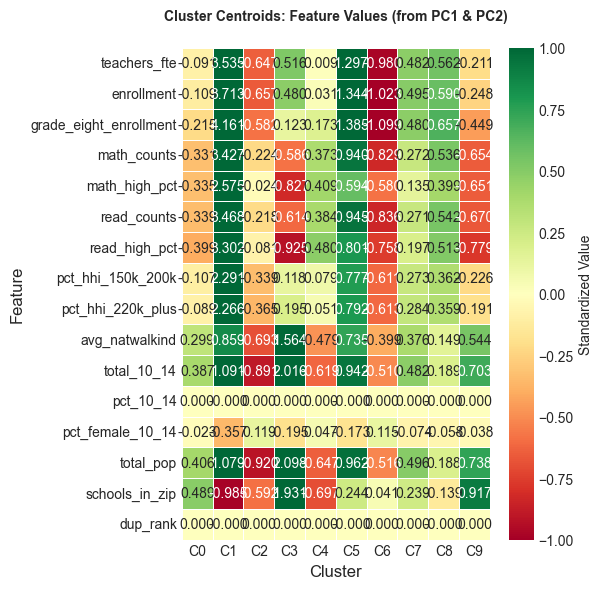


✅ Heatmap shows reconstructed feature values at each centroid
   • Green = Above average
   • Red = Below average
   • White/Yellow = Near average


In [20]:
# Simple heatmap showing centroid coordinates and feature contributions
# Run this in your notebook after creating centroids_2d

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names
feature_names = df_numeric.columns.tolist()

# Get PC loadings
pc1_loadings = pca_viz.components_[0]
pc2_loadings = pca_viz.components_[1]

# Calculate feature values at each centroid
centroid_features = []
for cluster_id in range(len(centroids_2d)):
    pc1_coord = centroids_2d[cluster_id, 0]
    pc2_coord = centroids_2d[cluster_id, 1]

    feature_values = []
    for i in range(len(feature_names)):
        total = (pc1_loadings[i] * pc1_coord) + (pc2_loadings[i] * pc2_coord)
        feature_values.append(total)

    centroid_features.append(feature_values)

# Create DataFrame
heatmap_df = pd.DataFrame(
    np.array(centroid_features).T,
    index=feature_names,
    columns=[f'C{i}' for i in range(len(centroids_2d))]
)

# Create heatmap
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(heatmap_df,
            annot=True,
            fmt='.3f',
            cmap='RdYlGn',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Standardized Value'},
            linewidths=0.5,
            ax=ax)

ax.set_title('Cluster Centroids: Feature Values (from PC1 & PC2)',
             fontsize=10, fontweight='bold', pad=20)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()

print("\n✅ Heatmap shows reconstructed feature values at each centroid")
print("   • Green = Above average")
print("   • Red = Below average")
print("   • White/Yellow = Near average")


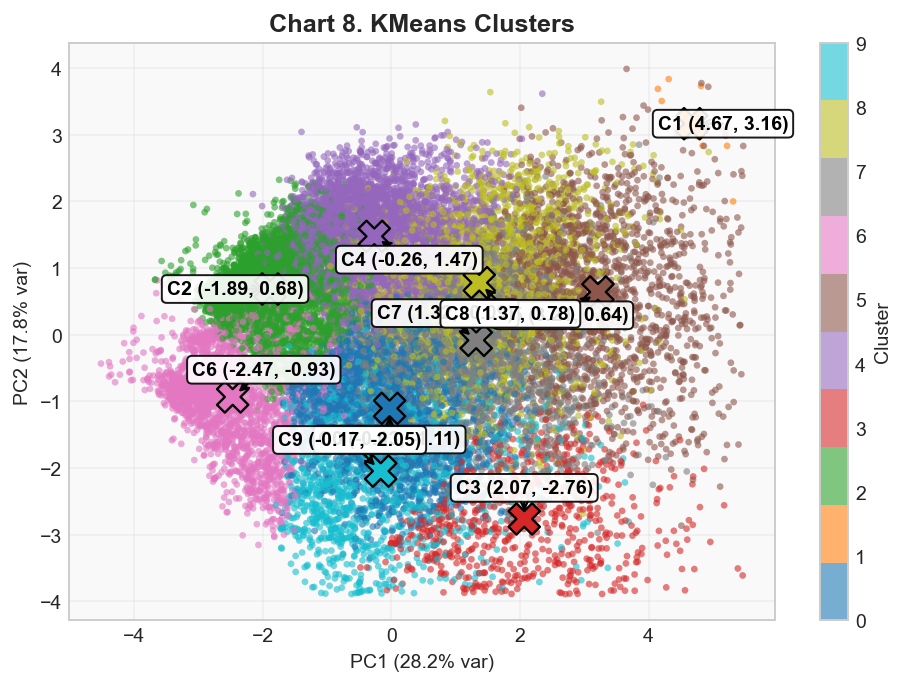

Saved chart (outliers dropped) to: D:\docs\MADS\696-Milestone 2\unsupervised\kmeans_clusters_best_params_clean.png


In [31]:
# Chart 8. KMeans Clusters — EXACT best_params with outlier drop on PC1 & PC2
# Uses saved best_params (k=10 expected), drops outliers in the 2D PCA viz space,
# simplifies colors, and improves centroid labels (includes coordinates).

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load saved best parameters
best_params_path = MODEL_DIR / 'kmeans_best_params.json'
if not best_params_path.exists():
    raise FileNotFoundError(f"best_params file not found at: {best_params_path}")

with open(best_params_path, 'r') as f:
    best_meta = json.load(f)

bp = best_meta.get('best_params', {})
if not bp:
    raise RuntimeError("No 'best_params' found in kmeans_best_params.json")

k = int(bp.get('kmeans_n_clusters', 10))
use_pca_flag = bool(bp.get('use_pca', False))
pca_components = int(bp.get('pca_components', 2))

# Prepare features exactly as in best_params for clustering
if use_pca_flag:
    pca_kmeans = PCA(n_components=pca_components, random_state=42)
    X_kmeans = pca_kmeans.fit_transform(X_full)
else:
    X_kmeans = X_full

# Fit KMeans exactly with best_params
kmeans_exact = KMeans(
    n_clusters=k,
    init=bp.get('kmeans_init', 'k-means++'),
    algorithm=bp.get('kmeans_algorithm', 'lloyd'),
    n_init=bp.get('kmeans_n_init', 'auto'),
    random_state=42
).fit(X_kmeans)

labels_kmeans = kmeans_exact.labels_

# 2D PCA for visualization only (project the original standardized space)
pca_viz = PCA(n_components=2, random_state=42)
X_2d = pca_viz.fit_transform(X_full)

# Drop outliers on both PC1 and PC2 using IQR rule (1.5 * IQR)
df_2d = pd.DataFrame({'PC1': X_2d[:, 0], 'PC2': X_2d[:, 1], 'cluster': labels_kmeans})
Q1_pc1, Q3_pc1 = df_2d['PC1'].quantile([0.25, 0.75])
IQR_pc1 = Q3_pc1 - Q1_pc1
lower_pc1, upper_pc1 = Q1_pc1 - 1.5 * IQR_pc1, Q3_pc1 + 1.5 * IQR_pc1

Q1_pc2, Q3_pc2 = df_2d['PC2'].quantile([0.25, 0.75])
IQR_pc2 = Q3_pc2 - Q1_pc2
lower_pc2, upper_pc2 = Q1_pc2 - 1.5 * IQR_pc2, Q3_pc2 + 1.5 * IQR_pc2

mask_keep = (
    (df_2d['PC1'].between(lower_pc1, upper_pc1)) &
    (df_2d['PC2'].between(lower_pc2, upper_pc2))
)

X_2d_keep = X_2d[mask_keep.values]
labels_keep = labels_kmeans[mask_keep.values]

# Centroids in the 2D plot space: mean of (filtered) projected points per cluster
centroids_2d = []
for c in range(k):
    sel = (labels_keep == c)
    if np.any(sel):
        centroids_2d.append(X_2d_keep[sel].mean(axis=0))
    else:
        # Fallback if a cluster lost all points after filtering
        centroids_2d.append(X_2d[labels_kmeans == c].mean(axis=0))
centroids_2d = np.vstack(centroids_2d)

# Plot with a simple color scheme (tab10) and improved labels
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7, 5), dpi=140)

scatter = ax.scatter(
    X_2d_keep[:, 0], X_2d_keep[:, 1],
    c=labels_keep,
    s=12,
    cmap='tab10',
    alpha=0.6,
    linewidths=0
)

ax.scatter(
    centroids_2d[:, 0], centroids_2d[:, 1],
    c=np.arange(k), cmap='tab10',
    marker='X', s=260, edgecolors='black', linewidths=1.2, zorder=3
)

# Improved centroid labels with coordinates and offsets to reduce overlap
text_offsets = [
    (0, -16), (16, 0), (-18, 0), (0, 16), (18, -12), (-18, -12), (16, 14), (-16, 14), (16, -16), (-16, 16)
]
for i, (cx, cy) in enumerate(centroids_2d):
    off = text_offsets[i % len(text_offsets)]
    ax.annotate(
        f"C{i} ({cx:.2f}, {cy:.2f})",
        xy=(cx, cy),
        xytext=off,
        textcoords='offset points',
        ha='center', va='center',
        fontsize=10, fontweight='bold', color='black',
        bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='black', alpha=0.9),
        arrowprops=dict(arrowstyle='->', color='black', lw=1.2, shrinkA=0, shrinkB=4)
    )

# Axis labels and title
ev = pca_viz.explained_variance_ratio_
ax.set_xlabel(f'PC1 ({ev[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({ev[1]*100:.1f}% var)')
ax.set_title(f'Chart 8. KMeans Clusters', fontsize=13, fontweight='bold')
ax.set_facecolor('#f9f9f9')
ax.grid(True, alpha=0.25)

# Simple colorbar
cbar = plt.colorbar(scatter, ticks=np.arange(k))
cbar.set_label('Cluster')

plt.tight_layout()

# Save and show
out_path = MODEL_DIR / 'kmeans_clusters_best_params_clean.png'
plt.savefig(out_path, dpi=160, bbox_inches='tight')
plt.show()
print(f"Saved chart (outliers dropped) to: {out_path}")

In [41]:
# Chart 9. Simplified — Feature Weights per Cluster + detailed_failures_df
# Produces a concise summary DataFrame (summary_df) and a tidy detailed failures DataFrame
# (detailed_failures_df) listing the top features per cluster by absolute standardized value.

import json
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load best params (same source as before)
best_params_path = MODEL_DIR / 'kmeans_best_params.json'
with open(best_params_path, 'r') as f:
    best_meta_fw = json.load(f)

bp_fw = best_meta_fw['best_params']
use_pca_flag_fw = bool(bp_fw.get('use_pca', False))
pca_components_fw = int(bp_fw.get('pca_components', 2))
k_fw = int(bp_fw.get('kmeans_n_clusters', 10))

# Prepare features exactly as clustering used
if use_pca_flag_fw:
    pca_kmeans_fw = PCA(n_components=pca_components_fw, random_state=42)
    X_kmeans_fw = pca_kmeans_fw.fit_transform(X_full)
else:
    pca_kmeans_fw = None
    X_kmeans_fw = X_full

# Fit KMeans with exact params
kmeans_fw = KMeans(
    n_clusters=k_fw,
    init=bp_fw.get('kmeans_init', 'k-means++'),
    algorithm=bp_fw.get('kmeans_algorithm', 'lloyd'),
    n_init=bp_fw.get('kmeans_n_init', 'auto'),
    random_state=42,
).fit(X_kmeans_fw)

# Centroids back in original standardized feature space
if pca_kmeans_fw is not None:
    centroids_orig = pca_kmeans_fw.inverse_transform(kmeans_fw.cluster_centers_)
else:
    centroids_orig = kmeans_fw.cluster_centers_

feature_names_fw = df_numeric.columns.tolist()
# DataFrame: rows=features, cols=clusters (C0..Ck)
summary_df = pd.DataFrame(
    centroids_orig,
    columns=feature_names_fw,
    index=[f'C{i}' for i in range(k_fw)]
).T

# Create a tidy DataFrame of top features per cluster (detailed failures)
TOP_N = 10  # configurable: how many top features per cluster to keep

long = summary_df.reset_index().melt(id_vars='index', var_name='cluster', value_name='std_value')
long = long.rename(columns={'index': 'feature'})
long['abs_value'] = long['std_value'].abs()
# Rank features within each cluster by absolute value (desc)
long['rank'] = long.groupby('cluster')['abs_value'].rank(method='first', ascending=False).astype(int)
# Keep top N per cluster
detailed_failures_df = (
    long[long['rank'] <= TOP_N]
    .sort_values(['cluster', 'rank'])
    .reset_index(drop=True)
)

# Add sign indicator for convenience
detailed_failures_df['sign'] = detailed_failures_df['std_value'].apply(lambda x: 'pos' if x > 0 else ('neg' if x < 0 else 'zero'))

# --- Robust saving: try MODEL_DIR, fall back to PROJECT_ROOT/outputs ---
from pathlib import Path

def safe_save_df(df: pd.DataFrame, path: Path, fmt='csv') -> Path | None:
    """Try to save df to path. On PermissionError, save to PROJECT_ROOT/outputs instead.
    Returns the actual path written or None on failure."""
    try:
        path.parent.mkdir(parents=True, exist_ok=True)
        if fmt == 'csv':
            df.to_csv(path)
        else:
            raise ValueError('unsupported format')
        return path
    except PermissionError:
        try:
            fallback = PROJECT_ROOT / 'outputs' / path.name
            fallback.parent.mkdir(parents=True, exist_ok=True)
            if fmt == 'csv':
                df.to_csv(fallback)
            return fallback
        except Exception as e:
            print(f"Failed to save to fallback path {fallback}: {e}")
            return None
    except Exception as e:
        print(f"Failed to save {path}: {e}")
        return None

# Save outputs for reporting
out_csv = MODEL_DIR / 'kmeans_cluster_feature_weights.csv'
actual_summary_path = safe_save_df(summary_df, out_csv)

out_detailed = MODEL_DIR / 'kmeans_detailed_failures.csv'
actual_detailed_path = safe_save_df(detailed_failures_df, out_detailed)

# Concise display for notebook
print("="*80)
print("SUMMARY: Features × Clusters (standardized centroid values)")
if actual_summary_path:
    print(f"summary_df saved to: {actual_summary_path}")
else:
    print("summary_df not saved (see warnings)")

display(summary_df.style.format('{:+.2f}'))

print("\nTop features per cluster (detailed_failures_df)")
if actual_detailed_path:
    print(f"detailed_failures_df saved to: {actual_detailed_path}")
else:
    print("detailed_failures_df not saved (see warnings)")

display(detailed_failures_df)

print("\nDone.")

SUMMARY: Features × Clusters (standardized centroid values)
summary_df saved to: D:\docs\MADS\696-Milestone 2\src\outputs\kmeans_cluster_feature_weights.csv


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
teachers_fte,-0.37,+4.06,-0.80,+0.09,-0.06,+1.32,-0.60,+0.63,+0.64,+0.25
enrollment,-0.38,+4.52,-0.82,+0.14,+0.02,+1.34,-0.66,+0.71,+0.53,+0.13
grade_eight_enrollment,-0.39,+5.09,-0.70,-0.01,+0.24,+1.35,-0.87,+0.71,+0.43,-0.28
math_counts,-0.43,+5.52,-0.35,-0.33,+0.70,+0.79,-0.72,+0.77,-0.31,-0.86
math_high_pct,+0.27,+0.35,+0.35,-0.13,+0.35,+0.64,-1.40,-0.44,+0.72,-1.44
read_counts,-0.44,+5.58,-0.35,-0.36,+0.71,+0.80,-0.72,+0.78,-0.31,-0.88
read_high_pct,+0.11,+1.62,+0.23,-0.30,+0.47,+0.82,-1.45,-0.25,+0.69,-1.48
pct_hhi_150k_200k,-0.13,-0.15,-0.25,-0.44,-0.38,+0.98,-0.55,-0.30,+1.50,+0.29
pct_hhi_220k_plus,-0.09,-0.31,-0.27,-0.36,-0.43,+1.00,-0.57,-0.32,+1.54,+0.32
avg_natwalkind,+0.34,-0.11,-0.64,+1.44,-0.63,+0.80,-0.44,+0.14,+0.55,+0.65



Top features per cluster (detailed_failures_df)
detailed_failures_df saved to: D:\docs\MADS\696-Milestone 2\unsupervised\kmeans_detailed_failures.csv


,feature,cluster,std_value,abs_value,rank,sign
0,schools_in_zip,C0,0.709910,0.709910,1,pos
1,total_pop,C0,0.561470,0.561470,2,pos
2,total_10_14,C0,0.548509,0.548509,3,pos
3,read_counts,C0,-0.442872,0.442872,4,neg
4,math_counts,C0,-0.430491,0.430491,5,neg
...,...,...,...,...,...,...
95,schools_in_zip,C9,0.477976,0.477976,6,pos
96,total_pop,C9,0.415048,0.415048,7,pos
97,total_10_14,C9,0.328414,0.328414,8,pos
98,pct_hhi_220k_plus,C9,0.317263,0.317263,9,pos



Done.


CLUSTER SIZES (best_params) — k=10


,Count,Percent,Centroid_PC1,Centroid_PC2
Cluster,,,,
C0,2631,11.42,-0.028,-1.106
C1,99,0.43,+8.553,+5.131
C2,4745,20.60,-1.886,+0.684
C3,1130,4.90,+2.108,-3.614
C4,3967,17.22,-0.265,+1.474
C5,1818,7.89,+3.388,+0.609
C6,2285,9.92,-2.467,-0.935
C7,2624,11.39,+1.319,-0.085
C8,2262,9.82,+1.367,+0.779


Saved cluster sizes table (with centroid coordinates) to: D:\docs\MADS\696-Milestone 2\unsupervised\kmeans_cluster_sizes.csv


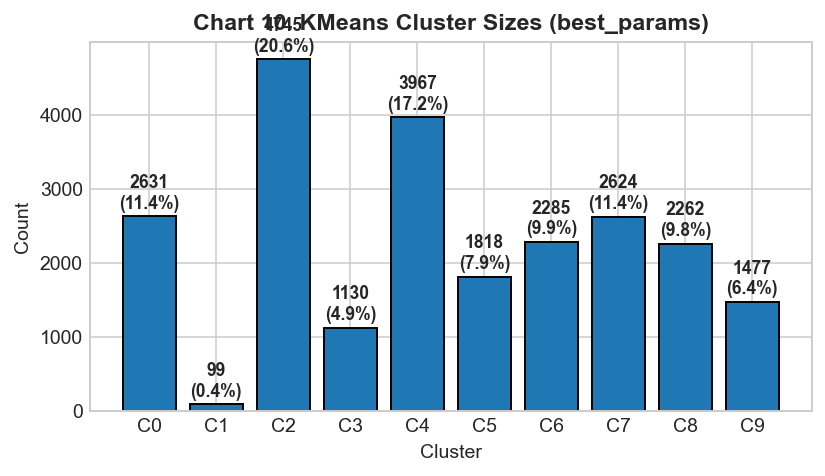

Saved cluster sizes chart to: D:\docs\MADS\696-Milestone 2\unsupervised\kmeans_cluster_sizes.png


In [ ]:
# Load saved best parameters
best_params_path = MODEL_DIR / 'kmeans_best_params.json'
with open(best_params_path, 'r') as f:
    best_meta_sizes = json.load(f)

bp_sizes = best_meta_sizes['best_params']
k_sizes = int(bp_sizes.get('kmeans_n_clusters', 10))
use_pca_sizes = bool(bp_sizes.get('use_pca', False))
pca_components_sizes = int(bp_sizes.get('pca_components', 2))

# Prepare features exactly as in best_params
if use_pca_sizes:
    pca_kmeans_sizes = PCA(n_components=pca_components_sizes, random_state=42)
    X_kmeans_sizes = pca_kmeans_sizes.fit_transform(X_full)
else:
    X_kmeans_sizes = X_full

# Fit KMeans using exact params
kmeans_sizes = KMeans(
    n_clusters=k_sizes,
    init=bp_sizes.get('kmeans_init', 'k-means++'),
    algorithm=bp_sizes.get('kmeans_algorithm', 'lloyd'),
    n_init=bp_sizes.get('kmeans_n_init', 'auto'),
    random_state=42
).fit(X_kmeans_sizes)

labels_sizes = kmeans_sizes.labels_

# Compute counts and percentages
counts = pd.Series(labels_sizes).value_counts().sort_index()
percent = (counts / counts.sum() * 100)

# Compute 2D PCA visualization centroids for coordinates in the plotted space
pca_viz_sizes = PCA(n_components=2, random_state=42)
X_2d_sizes = pca_viz_sizes.fit_transform(X_full)
centroids_2d = np.vstack([X_2d_sizes[labels_sizes == c].mean(axis=0) for c in range(k_sizes)])

# Build table with counts, percents, and centroid coordinates
idx_full = pd.Index(range(k_sizes), name='cluster_id')
counts = counts.reindex(idx_full, fill_value=0)
percent = percent.reindex(idx_full, fill_value=0.0).round(2)

sizes_df = pd.DataFrame({
    'Cluster': [f'C{i}' for i in idx_full],
    'Count': counts.values,
    'Percent': percent.values,
    'Centroid_PC1': centroids_2d[:, 0],
    'Centroid_PC2': centroids_2d[:, 1]
}).set_index('Cluster')

print("="*80)
print(f"CLUSTER SIZES (best_params) — k={k_sizes}")
print("="*80)
display(sizes_df.style.format({'Percent': '{:.2f}', 'Centroid_PC1': '{:+.3f}', 'Centroid_PC2': '{:+.3f}'}))

# Save table
sizes_csv = MODEL_DIR / 'kmeans_cluster_sizes.csv'
sizes_df.to_csv(sizes_csv)
print(f"Saved cluster sizes table (with centroid coordinates) to: {sizes_csv}")

# Bar chart of counts (kept simple and readable)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(6, 3.5), dpi=140)
ax.bar(sizes_df.index, sizes_df['Count'], color='#1f77b4', edgecolor='black')
for i, (cl, row) in enumerate(sizes_df.iterrows()):
    ax.text(i, row['Count'] + max(1, 0.01*max(1, sizes_df['Count'].max())),
            f"{int(row['Count'])}\n({row['Percent']:.1f}%)",
            ha='center', va='bottom', fontsize=9, fontweight='bold')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
ax.set_title('Chart 10. KMeans Cluster Sizes (best_params)', fontsize=12, fontweight='bold')
plt.tight_layout()

sizes_png = MODEL_DIR / 'kmeans_cluster_sizes.png'
plt.savefig(sizes_png, dpi=160, bbox_inches='tight')
plt.show()
print(f"Saved cluster sizes chart to: {sizes_png}")